## Imports and utils

In [30]:
import networkx as nx
import csv
import time
import pandas as pd
from cdlib import algorithms, readwrite, evaluation, NodeClustering
from cdlib.benchmark import LFR, SBM, GRP
import infomap
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def datafileToGraph(fileName):
    emailRaw = pd.read_csv(fileName, header=None)
    emailRaw = emailRaw[0].str.split(n=2, expand=True)
    emailRaw.columns = ['Source', 'Target']
    #print(emailRaw)
    emailNetwork = nx.from_pandas_edgelist(emailRaw, source='Source', target='Target', edge_attr=None)
    #nx.draw(emailNetwork)  
    return emailNetwork
emailNet = datafileToGraph('emailNet.txt')
print(emailNet)

Graph with 1005 nodes and 16706 edges


In [3]:
def averageDegree(networkx):
    degrees = [val for (node, val) in networkx.degree()]
    sum = 0
    for d in degrees:
        sum += d
    return sum/len(degrees)

In [2]:
def new_infomap(g_original: object, flags: str = "") -> NodeClustering:
    
    g1 = nx.convert_node_labels_to_integers(g_original, label_attribute="name")
    name_map = nx.get_node_attributes(g1, "name")
    coms_to_node = defaultdict(list)
    
    flags += " --silent"

    im = infomap.Infomap(flags)

    im.add_nodes(g_original.nodes)

    for source, target, data in g1.edges(data=True):
        if "weight" in data:
            im.add_link(source, target, data["weight"])
        else:
            im.add_link(source, target)
    im.run()

    for node_id, module_id in im.modules:
        node_name = name_map[node_id]
        coms_to_node[module_id].append(node_name)

    coms_infomap = [list(c) for c in coms_to_node.values()]
    
    return NodeClustering(
        coms_infomap, g_original, "Infomap", method_parameters={"flags": flags}
    )

## Email network properties 

In [5]:
print("Degree distribution:", nx.degree_histogram(emailNet))
print("Average degree:", averageDegree(emailNet))
print("Clustering coefficient:", nx.average_clustering(emailNet))

for C in (emailNet.subgraph(c) for c in nx.connected_components(emailNet)):
    print("Average Path Length:", nx.average_shortest_path_length(C))
    break
    
#centrality

Degree distribution: [0, 78, 46, 42, 33, 28, 21, 25, 20, 15, 14, 20, 15, 16, 14, 14, 12, 9, 12, 15, 18, 15, 16, 13, 16, 18, 14, 11, 12, 20, 19, 11, 10, 8, 9, 8, 11, 11, 9, 6, 7, 9, 8, 7, 7, 9, 9, 8, 7, 5, 6, 9, 8, 7, 7, 8, 5, 4, 3, 3, 4, 5, 5, 6, 5, 2, 1, 2, 3, 2, 4, 5, 4, 5, 6, 1, 3, 1, 1, 1, 3, 2, 1, 5, 6, 3, 4, 2, 1, 1, 0, 3, 3, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 1, 0, 1, 3, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Community finding methods for the email network

In [6]:
start_time = time.time()
emailLouvain = algorithms.louvain(emailNet)
print("Execution time for Louvain in email net: %.6s seconds" % (time.time() - start_time))
start_time = time.time()
emailGN = algorithms.girvan_newman(emailNet, level=3)
print("Execution time for Girvan-Newman in email net: %.6s seconds" % (time.time() - start_time))
#start_time = time.time()
#emailKC = algorithms.kclique(emailNet, k=10)
#print("Execution time for KCliques in email net: %.6s seconds" % (time.time() - start_time))
#print("Execution time for Infomap in email net: %.6s seconds" % (time.time() - start_time))

Execution time for Louvain in email net: 0.3861 seconds
Execution time for Girvan-Newman in email net: 117.05 seconds


## Louvain properties

In [7]:
size = evaluation.size(emailNet, emailLouvain)
ad = evaluation.avg_distance(emailNet, emailLouvain)
aid = evaluation.average_internal_degree(emailNet, emailLouvain)
ae = evaluation.avg_embeddedness(emailNet, emailLouvain)
at = evaluation.avg_transitivity(emailNet, emailLouvain)
hd = evaluation.hub_dominance(emailNet, emailLouvain)
s = evaluation.significance(emailNet, emailLouvain)

print("Louvain Size:", size)
print("Louvain Average Path Length:",  ad)
print("Louvain Average Internal Degree:",  aid)
print("Louvain Average Embeddedness:",  ae)
print("Louvain Average Transitivity:",  at)
print("Louvain Hub Dominance:",  hd)
print("Louvain Significance:", s)

Louvain Size: FitnessResult(min=1, max=230, score=37.22222222222222, std=62.29460076082531)
Louvain Average Path Length: FitnessResult(min=0, max=2.3660979543332483, score=0.6429547552898583, std=0.9949746091964978)
Louvain Average Internal Degree: FitnessResult(min=2.0, max=24.607142857142858, score=7.1401008137833, std=8.144955788158892)
Louvain Average Embeddedness: FitnessResult(min=0.5440640558076698, max=1.0, score=0.9157798467341185, std=0.136495300046512)
Louvain Average Transitivity: FitnessResult(min=0.0, max=0.7293503931679288, score=0.1591499429436357, std=0.2493696795105279)
Louvain Hub Dominance: FitnessResult(min=0.42358078602620086, max=0.7301587301587301, score=0.5537905274163827, std=0.09659450802008697)
Louvain Significance: FitnessResult(min=None, max=None, score=61113.62956594368, std=None)


In [9]:
#louvainDict = louvain.to_node_community_map()
#print(louvainDict)
#louvain.to_json()

## Girvan-Newman

In [10]:
size = evaluation.size(emailNet, emailGN)
ad = evaluation.avg_distance(emailNet, emailGN)
aid = evaluation.average_internal_degree(emailNet, emailGN)
ae = evaluation.avg_embeddedness(emailNet, emailGN)
at = evaluation.avg_transitivity(emailNet, emailGN)
hd = evaluation.hub_dominance(emailNet, emailGN)
s = evaluation.significance(emailNet, emailGN)

print("Girvan-Newman Size:", size)
print("Girvan-Newman Average Path Length:",  ad)
print("Girvan-Newman Average Internal Degree:",  aid)
print("Girvan-Newman Average Embeddedness:",  ae)
print("Girvan-Newman Average Transitivity:",  at)
print("Girvan-Newman Hub Dominance:",  hd)
print("Girvan-Newman Significance:", s)

Girvan-Newman Size: FitnessResult(min=1, max=978, score=43.69565217391305, std=199.1969605981256)
Girvan-Newman Average Path Length: FitnessResult(min=0, max=2.5665982212565908, score=0.1927506473010112, std=0.6330518282579853)
Girvan-Newman Average Internal Degree: FitnessResult(min=0.0, max=34.08997955010225, score=3.235796212323286, std=6.602873143511623)
Girvan-Newman Average Embeddedness: FitnessResult(min=0.0, max=1.0, score=0.9057542629926452, std=0.2815706562689681)
Girvan-Newman Average Transitivity: FitnessResult(min=0.0, max=0.4108588094169628, score=0.017863426496389688, std=0.08378689716311363)
Girvan-Newman Hub Dominance: FitnessResult(min=0.35516888433981575, max=1.2, score=0.7775844421699079, std=0.4224155578300921)
Girvan-Newman Significance: FitnessResult(min=None, max=None, score=78331.79378130106, std=None)


## Modularity

In [11]:
louvainGN = evaluation.newman_girvan_modularity(emailNet, emailLouvain)
louvainER = evaluation.erdos_renyi_modularity(emailNet, emailLouvain)
louvainZ = evaluation.z_modularity(emailNet, emailLouvain)

print("Louvain Girvan-Newman mod:", louvainGN)
print("Louvain Erdos-Renyi mod:", louvainER)
print("Louvain Z-mod:", louvainZ)

Louvain Girvan-Newman mod: FitnessResult(min=None, max=None, score=0.4326447395710833, std=None)
Louvain Erdos-Renyi mod: FitnessResult(min=None, max=None, score=0.45046874723811403, std=None)
Louvain Z-mod: FitnessResult(min=None, max=None, score=1.1869576999709814, std=None)


## External Evaluation

In [12]:
nmi = evaluation.normalized_mutual_information(emailLouvain, emailGN)
ami = evaluation.adjusted_mutual_information(emailLouvain, emailGN)
ari = evaluation.adjusted_rand_index(emailLouvain, emailGN)
f1 = evaluation.f1(emailLouvain, emailGN)
voi = evaluation.variation_of_information(emailLouvain, emailGN)

print("Normalized Mutual Information between Louvain and Girvan-Newman:", nmi)
print("Adjusted Mutual Information between Louvain and Girvan-Newman:", ami)
print("Adjusted Rand Index between Louvain and Girvan-Newman:", ari)
print("F1 measure between Louvain and Girvan-Newman:", f1)
print("Variation of information between Louvain and Girvan-Newman:", voi)

Normalized Mutual Information between Louvain and Girvan-Newman: MatchingResult(score=0.14375880880788014, std=None)
Adjusted Mutual Information between Louvain and Girvan-Newman: MatchingResult(score=0.10574826763710264, std=None)
Adjusted Rand Index between Louvain and Girvan-Newman: MatchingResult(score=0.01346971650042717, std=None)
F1 measure between Louvain and Girvan-Newman: MatchingResult(score=0.7685185185185185, std=0.3593585200789885)
Variation of information between Louvain and Girvan-Newman: MatchingResult(score=2.854934021362194, std=None)


## Email Labels import 

In [13]:
def convertTextDatasetToCSV(txtFile, csvFile):
    txtFile = open(txtFile, 'r')
    
    txtLines = txtFile.readlines()
    csvLines = {}
    
    for line in txtLines:
        lineVec = line[:-1].split(' ')
        if lineVec[1] in csvLines.keys():
            csvLines[lineVec[1]].append(lineVec[0])
        else:
            csvLines[lineVec[1]] = [lineVec[0]]
            
    with open(csvFile, 'w',newline="") as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in csvLines.items():
            writer.writerow(value)
        
convertTextDatasetToCSV('emailLabels.txt', 'emailLabels.csv')
emailLabels = readwrite.read_community_csv("emailLabels.csv", ",", str)

In [14]:
nmiLouvainLabels = emailLouvain.normalized_mutual_information(emailLabels)
nmiGirvanNewmanLabels = emailGN.normalized_mutual_information(emailLabels)

amiLouvainLabels = emailLouvain.adjusted_mutual_information(emailLabels)
amiGirvanNewmanLabels = emailGN.adjusted_mutual_information(emailLabels)

ariLouvainLabels = emailLouvain.adjusted_rand_index(emailLabels)
ariGirvanNewmanLabels = emailGN.adjusted_rand_index(emailLabels)

f1LouvainLabels = emailLouvain.f1(emailLabels)
f1GirvanNewmanLabels = emailGN.f1(emailLabels)

voiLouvainLabels = emailLouvain.variation_of_information(emailLabels)
voiGirvanNewmanLabels = emailGN.variation_of_information(emailLabels)

print("NMI for Louvain and labels:", nmiLouvainLabels)
print("NMI for Girvan-Newman and labels:", nmiGirvanNewmanLabels)
print()
print("AMI for Louvain and labels:", amiLouvainLabels)
print("AMI for Girvan-Newman and labels:", amiGirvanNewmanLabels)
print()
print("ARI for Louvain and labels:", ariLouvainLabels)
print("NMI for Girvan-Newman and labels:", ariGirvanNewmanLabels)
print()
print("F1 for Louvain and labels:", f1LouvainLabels)
print("F1 for Girvan-Newman and labels:", f1GirvanNewmanLabels)
print()
print("VOI for Louvain and labels:", voiLouvainLabels)
print("VOI for Girvan-Newman and labels:", voiGirvanNewmanLabels)

NMI for Louvain and labels: MatchingResult(score=0.6023537592816649, std=None)
NMI for Girvan-Newman and labels: MatchingResult(score=0.0449480988954229, std=None)

AMI for Louvain and labels: MatchingResult(score=0.5680700585431959, std=None)
AMI for Girvan-Newman and labels: MatchingResult(score=-0.0005067215292382119, std=None)

ARI for Louvain and labels: MatchingResult(score=0.3507150977474317, std=None)
NMI for Girvan-Newman and labels: MatchingResult(score=-0.0012481583268392242, std=None)

F1 for Louvain and labels: MatchingResult(score=0.21592592592592597, std=0.2780122467227772)
F1 for Girvan-Newman and labels: MatchingResult(score=0.05695652173913045, std=0.050599431394699676)

VOI for Louvain and labels: MatchingResult(score=3.1133167699097295, std=None)
VOI for Girvan-Newman and labels: MatchingResult(score=4.848380933791979, std=None)


## LFR 

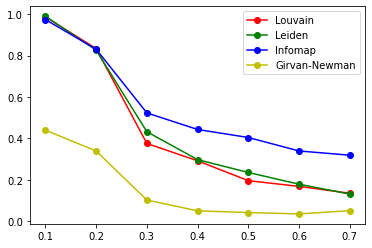

In [28]:
n = 500
tau1 = 3
tau2 = 1.5
#mu = 0.1
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

resultsLouvain = []
resultsLeiden = []
resultsInfomap = []
resultsGN = []

for mu in tqdm(mus):
    lfrGraph, comsLFR = LFR(n, tau1, tau2, mu, average_degree=5, min_community=20)
    
    lfrLouvain = algorithms.louvain(lfrGraph)
    lfrLeiden = algorithms.leiden(lfrGraph)
    lfrInfomap = new_infomap(lfrGraph, "-N 2")
    lfrGN = algorithms.girvan_newman(lfrGraph, level=3)
    
    nmi1 = evaluation.normalized_mutual_information(lfrLouvain, comsLFR)
    resultsLouvain.append(nmi1[0])
    nmi2 = evaluation.normalized_mutual_information(lfrLeiden, comsLFR)
    resultsLeiden.append(nmi2[0])
    nmi3 =  evaluation.normalized_mutual_information(lfrInfomap, comsLFR)
    resultsInfomap.append(nmi3[0])
    nmi4 =  evaluation.normalized_mutual_information(lfrGN, comsLFR)
    resultsGN.append(nmi4[0])
    


plt.plot(mus,resultsLouvain, "-ro", label = "Louvain")
plt.plot(mus,resultsLeiden, "-go", label = "Leiden")
plt.plot(mus,resultsInfomap, "-bo", label = "Infomap")
plt.plot(mus,resultsGN, "-yo", label = "Girvan-Newman")
plt.legend()
plt.show()

## SBM 

In [ ]:
resultsLouvain = []
resultsLeiden = []
resultsInfomap = []

mus = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

sizes = [32, 32, 32, 32]
for c in tqdm(mus):
    probs = [[1-c, c, c, c], [c, 1-c, c, c], [c, c, 1-c, c],[c, c, c, 1-c]]
    sbmGraph, comsSBM = SBM(sizes, probs, seed=10)

    sbmLouvain = algorithms.louvain(sbmGraph)
    sbmLeiden = algorithms.leiden(sbmGraph)
    sbmInfomap = new_infomap(sbmGraph, "-N 2")
    sbmGN = algorithms.girvan_newman(sbmGraph, level=3)

    nmi1 = evaluation.normalized_mutual_information(sbmLouvain, comsSBM)
    resultsLouvain.append(nmi1[0])
    nmi2 = evaluation.normalized_mutual_information(sbmLeiden, comsSBM)
    resultsLeiden.append(nmi2[0])
    nmi3 =  evaluation.normalized_mutual_information(sbmInfomap, comsSBM)
    resultsInfomap.append(nmi3[0])
    nmi4 =  evaluation.normalized_mutual_information(sbmGN, comsSBM)
    resultsGN.append(nmi4[0])

plt.plot(mus,resultsLouvain, "-ro", label = "Louvain")
plt.plot(mus,resultsLeiden, "-go", label = "Leiden")
plt.plot(mus,resultsInfomap, "-bo", label = "Infomap")
plt.plot(mus,resultsGN, "-yo", label = "Girvan-Newman")
plt.legend()
plt.show()


 91%|█████████ | 10/11 [09:00<01:06, 66.97s/it]

## GRP


In [ ]:
consts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
resultsLouvain = []
resultsLeiden = []
resultsInfomap = []

for c in tqdm(consts):
    mean = 10 * c
    shape = 10 * c/2
    grpGraph, comsGRP = GRP(500, mean, shape, 0.25, 0.1)
    
    grpLouvain = algorithms.louvain(grpGraph)
    grpLeiden = algorithms.leiden(grpGraph)
    grpInfomap = new_infomap(grpGraph, "-N 2")
    grpGN = algorithms.girvan_newman(grpGraph, level=3)
    
    nmi1 = evaluation.normalized_mutual_information(grpLouvain, comsGRP)
    resultsLouvain.append(nmi1[0])
    nmi2 = evaluation.normalized_mutual_information(grpLeiden, comsGRP)
    resultsLeiden.append(nmi2[0])
    nmi3 =  evaluation.normalized_mutual_information(grpInfomap, comsGRP)
    resultsInfomap.append(nmi3[0])
    nmi4 =  evaluation.normalized_mutual_information(grpGN, comsGRP)
    resultsGN.append(nmi4[0])
    

plt.plot(consts,resultsLouvain, "-ro", label = "Louvain")
plt.plot(consts,resultsLeiden, "-go", label = "Leiden")
plt.plot(consts,resultsInfomap, "-bo", label = "Infomap")
plt.plot(consts,resultsGN, "-yo", label = "Girvan-Newman")
plt.legend()
plt.show()

100%|██████████| 22/22 [00:00<00:00, 78398.21it/s]

22
